In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

from fuzzywuzzy import process


# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "correct_return_periods.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path, get_data_paths, setup_root_paths
setup_project_paths(PATH)


#from utils_plotting import plot_time_series, plot_random_monthly_and_yearly_data, plot_feature_histograms, plot_contry_period_map
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
from utils_p_i import calculate_p_i
from utils_P_i import calculate_P_i

#from utils_likelihoods import calculate_likelihood_of_at_least_one_event

from utils_return_periods import calculate_return_periods

#from utils_global_probabilities import calculate_global_probabilities
#from utils_country_probabilities import calculate_all_country_probabilities
#from utils_check_expected_features import check_expected_features    
#from utils_date_index import calculate_date_from_index 
#from utils_country_id_csv_to_json import country_id_csv_to_json

from utils_get_country_names_by_ids import get_country_names_by_ids
from utils_get_country_id_by_name import get_country_id_by_name

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
PATH_RAW_VIEWSER, PATH_RAW_EXTERNAL, PATH_PROCESSED, PATH_GENERATED = get_data_paths(PATH)

In [4]:
# # load the data from pkl
# df_monthly = pd.read_pickle(PATH_RAW_VIEWSER / "simon_full_base_01_viewser_df.pkl")
# 
# df_yearly = aggregate_monthly_to_yearly(df_monthly)
# 
# # Feature engineering
# df_monthly = feature_eng_fat_per_100k(df_monthly)
# df_yearly = feature_eng_fat_per_100k(df_yearly)
# 
# # save the data
# df_monthly.to_pickle(PATH_PROCESSED / "df_monthly_new.pkl")  
# df_yearly.to_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [5]:
# load the data
df_monthly = pd.read_pickle(PATH_PROCESSED / "df_monthly_new.pkl")
df_yearly = pd.read_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [6]:
get_country_id_by_name("Mali")

[(50, 'Mali'), (120, 'Somalia'), (161, 'Malawi')]

In [7]:
def update_df_with_probabilities_and_return_periods_pretest(df, feature):

    # check that it is a pandas dataframe
    if not isinstance(df, pd.DataFrame):
        raise ValueError('df is not a pandas dataframe')

    # check the df is not empty
    if df.empty:
        raise ValueError('DataFrame is empty')

    # checkt that the time period is present
    time_period_column = ['month_id', 'year_id']
    
    if time_period_column[0] not in df.columns and time_period_column[1] not in df.columns:
        raise ValueError('Time period not found')

    # check that the other relevant columns are present
    relevant_columns = ['pg_id', 'c_id', 'row', 'col', feature]
    for column in relevant_columns:
        if column not in df.columns:
            raise ValueError(f'{column} not found in df')

    # check that the feature is not empty
    if df[feature].isnull().all():
        raise ValueError(f'{feature} is empty')

    # check that the feature is not negative
    if (df[feature] < 0).any():
        raise ValueError(f'{feature} contains negative values')

    # check for null, inf and nan
    if df.isnull().values.any():
        raise ValueError('DataFrame contains NaN values')

    if np.isinf(df.values).any():
        raise ValueError('DataFrame contains infinite values')

    return True


def get_time_period(df):
    
    if 'month_id' in df.columns:
        return 'month_id'
    
    elif 'year_id' in df.columns:
        return 'year_id'
    
    else:
        print(df.columns)
        #raise ValueError('Time period not found')
    

def check_region_id(region_id_type, region_id, df):

    """
    
    """

    if region_id_type == 'pg_ids':
        # chekc that the region_id is present in the df pg_ids
        if region_id not in df['pg_id'].unique():
            raise ValueError(f'{region_id} not found in pg_id column')
        
    elif region_id_type == 'c_ids':
        # chekc that the region_id is present in the df c_ids
        if region_id not in df['c_id'].unique():
            raise ValueError(f'{region_id} not found in c_id column')
        
    elif region_id_type == 'global':
        pass

    else:
        raise ValueError(f'{region_id_type} not recognized')

    return True

def subset_regional_df(df, region_id_type, region_id):

    """

    """

    if region_id_type == 'pg_ids':
        sub_df = df[df['pg_id'] == region_id].copy()
        
    elif region_id_type == 'c_ids':
        sub_df = df[df['c_id'] == region_id].copy()
        
    elif region_id_type == 'global':
        sub_df = df.copy()

    else:
        raise ValueError(f'{region_id_type} not recognized')
    
    return sub_df

def update_df_with_probabilities_and_return_periods(df, feature, region_id_type, region_id):

    """

    """

    update_df_with_probabilities_and_return_periods_pretest(df, feature)
    check_region_id(region_id_type, region_id, df)
    time_period = get_time_period(df)

    # sub set the df according to the region_id_type and region_id - if global, then the whole df is used but we still do this for consistency
    sub_df = subset_regional_df(df, region_id_type, region_id)


    feature_series = sub_df[feature]
    n_cells = sub_df['pg_id'].unique().shape[0] # THIS WOULD ONLT CHANGE IF WE AGGREGATE THE PRIO GRID CELLS

    # calculate the probabilities and return periods
    df_probabilities = calculate_p_i(feature_series)
    df_probabilities = calculate_P_i(df_probabilities, n_cells)
    df_probabilities = calculate_return_periods(df_probabilities)

    # rename the calculated columns to match the original df feature
    df_probabilities.rename(columns={'value': feature, 'value_count' : f'{feature}_value_count', 'p_i' : f"{feature}_p_i", 'P_i' : f"{feature}_P_i", 'e_i' : f"{feature}_e_i", 'E_i' : f"{feature}_E_i"}, inplace=True)

    # Merge
    merged_df = pd.merge(sub_df, df_probabilities, on=[feature], how='left')

    # check for null, inf and nan
    if merged_df.isnull().values.any():
        raise ValueError('DataFrame contains NaN values')

    return merged_df


In [8]:
#contry_id = 50
feature = 'fatalities_per_100k'
region_id_type = 'global' # pg_ids, c_ids, or global
region_id = None

In [9]:
new_df_monthly = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, region_id)
new_df_yearly = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, region_id)

In [12]:
new_df_yearly.describe()

,pg_id,year_id,c_id,col,row,sb_best,ns_best,os_best,pop_gpw_sum,total_best,fatalities_per_100k,sb_per_100k,ns_per_100k,os_per_100k,fatalities_per_100k_value_count,fatalities_per_100k_p_i,fatalities_per_100k_P_i,fatalities_per_100k_e_i,fatalities_per_100k_E_i
count,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,4.588500e+05,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000,458850.000000
mean,144794.092982,2006.000000,141.969282,407.676506,201.536690,0.243844,0.043358,0.060941,1.035208e+06,0.348144,0.039114,0.023447,0.008095,0.007572,424936.963644,0.963046,0.999925,11.293104,1.000316
std,26708.184196,10.099516,65.657048,36.670957,37.095851,11.636332,1.786757,1.934838,3.160236e+06,12.696437,1.145011,0.699384,0.782681,0.251318,84066.232054,0.186808,0.006084,868.668673,0.063541
min,62356.000000,1989.000000,40.000000,310.000000,87.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000002,0.028167,1.000000,1.000000
25%,126436.000000,1997.000000,70.000000,383.000000,176.000000,0.000000,0.000000,0.000000,4.229768e+04,0.000000,0.000000,0.000000,0.000000,0.000000,441568.000000,1.000000,1.000000,1.000000,1.000000
50%,149457.500000,2006.000000,157.000000,410.000000,208.000000,0.000000,0.000000,0.000000,2.637639e+05,0.000000,0.000000,0.000000,0.000000,0.000000,441568.000000,1.000000,1.000000,1.000000,1.000000
75%,166012.000000,2015.000000,213.000000,435.000000,231.000000,0.000000,0.000000,0.000000,9.264214e+05,0.000000,0.000000,0.000000,0.000000,0.000000,441568.000000,1.000000,1.000000,1.000000,1.000000
max,190511.000000,2023.000000,246.000000,487.000000,265.000000,3131.000000,645.000000,969.000000,1.489921e+08,3221.000000,441.995180,136.282565,441.995180,87.019180,441568.000000,1.000000,1.000000,458850.000000,35.502343


NameError: name 'new_df' is not defined

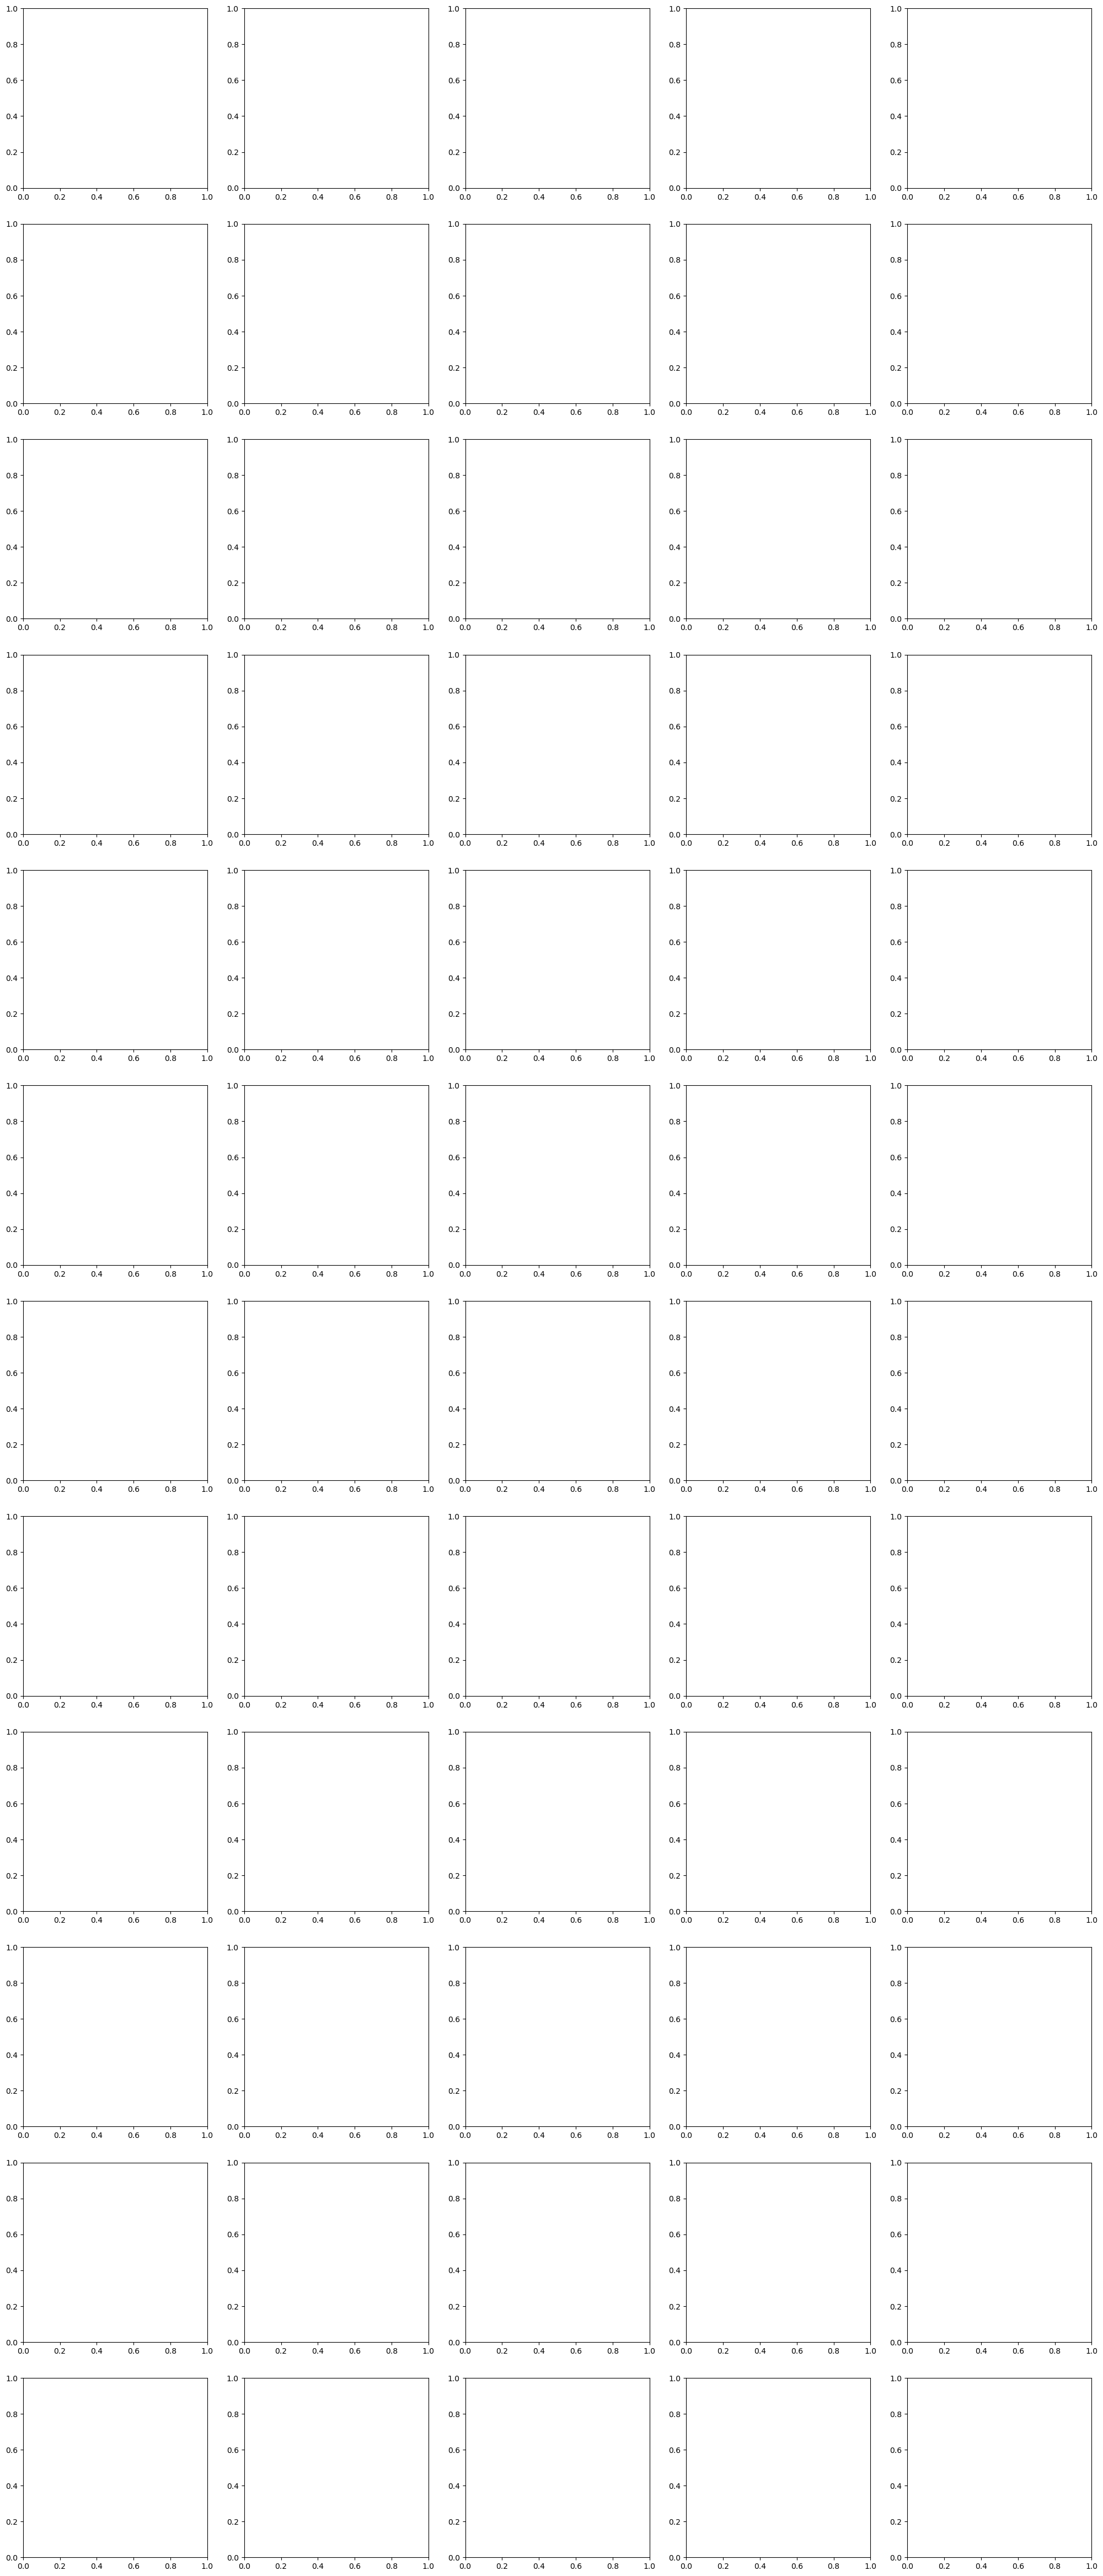

In [10]:
features_list = [feature, f'{feature}_p_i', f'{feature}_P_i', f'{feature}_e_i', f'{feature}_E_i']
month_range = np.arange(121, 133)

fig, axs = plt.subplots(len(month_range), len(features_list), figsize=(25, 5 * len(month_range)))

for row_idx, month_id in enumerate(month_range):

    for col_idx, feature_name in enumerate(features_list):

        # Determine colormap and value range
        if 'P_i' in feature_name or 'p_i' in feature_name:
            cmap = 'rainbow_r'
            vmin = 0
            vmax = 1
        else:
            cmap = 'rainbow'
            vmin = new_df[new_df['month_id'] == month_id][feature_name].min()
            vmax = new_df[new_df['month_id'] == month_id][feature_name].max()

        # Extract the data for the specific month_id
        month_data = new_df[new_df['month_id'] == month_id]

        # Calculate the grid size based on min and max row and col values
        min_row = month_data['row'].min()
        max_row = month_data['row'].max()
        min_col = month_data['col'].min()
        max_col = month_data['col'].max()

        # Create the grid with adjusted size
        grid_rows = max_row - min_row + 1
        grid_cols = max_col - min_col + 1
        grid = np.full((grid_rows, grid_cols), np.nan)

        # Fill the grid with the feature_name values, adjusting for min_row and min_col
        for _, row in month_data.iterrows():
            grid[int(row['row']) - min_row, int(row['col']) - min_col] = row[feature_name]

        # Plot with imshow
        cax = axs[row_idx, col_idx].imshow(grid, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
        fig.colorbar(cax, ax=axs[row_idx, col_idx], orientation='vertical', label=feature_name)

plt.tight_layout()
plt.show()

# BETTER NAMING BEFORE ANYTHING ELSE!!!!



In [ ]:
return_periods = calculate_return_periods(liklihood, 'cdf', 'likelihood')

In [ ]:
return_periods

In [ ]:
liklihood['cdf']

In [ ]:
plt.hist(liklihood, bins=100)
plt.show()

In [ ]:
return_periods = calculate_return_periods(cdf, liklihood, 10000)